In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sksurv.metrics import concordance_index_censored
import numpy as np
import scipy.stats
from functools import partial
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

In [2]:
import sys
from pathlib import Path
from joblib import Parallel, delayed
import json

In [3]:
def mean_confidence_interval(data, confidence=0.95):
    """Calculate mean, and lower and upper bound of confidence interval"""
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [4]:
def Dxy(event_observed, cve_lifetime, predicted_scores):
    """Calculate Dxy

    Rescale values from 0<=x<=1 range, where 0 is perfect anti-concordance,
    and 0.5 is the expected result from random predictions,
    to the -1<=x<=1 range
    """
    #return 2 * concordance_index_censored(event_observed, cve_lifetime, predicted_scores)[0] - 1
    return 2 * concordance_index(cve_lifetime, predicted_scores, event_observed) - 1

In [5]:
def bootstrap_dxy_inner(df):
    """Bootstrapped Dxy calculation, randomly sampled with replacement

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe to sample to compute Dxy from concordance index.
        Assumes that first 3 columns in this dataframe are:

        1. boolean column denoting which events were observed (un-censored)
        2. column with event times, in this case CVE lifetime (time to fix)
        3. column with predicted score, assumed to be category number,
           ordered in such way that larger values predict shorter lifetime

        Other columns are not used.

    Returns
    -------
    float
        Coefficient of concordance correlation, a number between –1 and 1 that
        measures the strength and direction of the relationship between
        predicted score (risk factor) and event time (CVE survival lifetime).
    """
    e, y, x = df.columns
    sample = df.sample(n=df.shape[0], replace=True)

    # calculate Dxy from sample
    return Dxy(sample[e], sample[y], sample[x])


def bootstrap_dxy(df, n=5):
    """Boostrap and calculate Dxy, resampling `n` times"""
    # resample n times
    result = Parallel(n_jobs=-1)(delayed(bootstrap_dxy_inner)(df) for _ in range(n))

    return result

In [6]:
def apply_stats_for_each_value(params, df, fmap, condition_names=None, df_mask=None):
    """Apply stats to each value in column"""

    all_count = df.shape[0]

    if df_mask is not None:
        df = df[df_mask]

    dff = pd.DataFrame({'E': df['E'], 'Y': df['Y'], 'agg': df.apply(fmap, axis=1)}).dropna()
    selected_count = dff.shape[0]
    print(f"all = {all_count}, selected = {selected_count}, uncensored = {dff['E'].sum()}",
               file=sys.stderr)

    # DEBUG
    #print(dff.head())

    stats = dff['Y'].aggregate(['count', 'median'])

    print(f"Computing {params['bootstrap_samples']} × bootstrap Dxy " +
          f"for {dff.shape[0]} elements...", file=sys.stderr)
    dxy_bootstrapped = bootstrap_dxy(dff[['E', 'Y', 'agg']], params['bootstrap_samples'])
    # DEBUG
    #print(dxy_bootstrapped)
    # confidence interval
    print(f"Computing confidence interval from {len(dxy_bootstrapped)} samples...", file=sys.stderr)
    dxy, ci_low, ci_high = mean_confidence_interval(dxy_bootstrapped, confidence=params['confidence'])

    ret = {
        'Cohort': all_count,
        'Number of patients': stats['count'],
        '% of cohort': 100.0*selected_count / all_count,
        'Survival days, median': stats['median'],
        'Survival years, median': stats['median'] / 365,
        'Dxy (full)': Dxy(dff['E'], dff['Y'], dff['agg']),
        'bootstrap': {
            'Dxy': dxy,
            'Confidence interval low': ci_low,
            'Confidence interval high': ci_high,
            'confidence threshold %': 100.0*params['confidence'],
            'bootstrap samples': params['bootstrap_samples'],
        },
    }

    print("Computing descriptive statistics like mean, median, etc....", file=sys.stderr)
    dff_groupby_y = dff.groupby(by=['agg'])['Y']
    groups = dff_groupby_y\
        .agg(['count', 'median', 'min',
              lambda x: np.percentile(x, q=25), lambda x: np.percentile(x, q=75),
              'max', 'mean', 'std', 'skew'])\
        .rename(columns={'<lambda_0>': '25%', '<lambda_1>': '75%'})

    # DEBUG
    #print(dff_groupby_y.describe())

    groups.index.names = [ params['risk_column_name'] ]
    if condition_names:
        groups.index = groups.index.map(condition_names)

    return ret, groups, dff

In [7]:
def plot_survival_function(params, dff, condition_names=None):
    """Create plot of survival function

    Parameters
    ----------
    params : dict
        Uses params['cve_survival_analysis']['risk_column_name'] and
        params['description'] to create plot titles
    plot_path : str | pathlib.Path
        Where to save the plot
    dff : pandas.DataFrame
        The dataframe with data to compute survival function from
    condition_names : dict | None
        Mapping from risk factor score to risk factor name
    """
    values_list = dff["agg"].unique()
    if condition_names is not None:
        values_list = condition_names.keys()
    print(f"values_list = {values_list}")
    for value in values_list:
        mask = (dff["agg"] == value)  # it's a boolean-valued pd.Series
        time_cell, survival_prob_cell = kaplan_meier_estimator(dff["E"][mask], dff["Y"][mask])
        plt.step(time_cell, survival_prob_cell, where="post",
                 label=f"{condition_names[value]} (n = {mask.sum():d})"
                       if condition_names else
                       f"{value:d} (n = {mask.sum():d})"
                 )

    if 'risk_column_name' in params:
        plt.suptitle(f"Risk factor: '{params['risk_column_name']}'")
    if 'description' in params:
        plt.title(params['description'])
    plt.ylabel("est. probability of survival $\\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.legend(loc="best")
    plt.show()
    # plt.savefig(plot_path)
    plt.clf()

In [8]:
def create_values_ranking_list(column_s, column_dtype):
    # if column_dtype is ordered category, we can use the order;
    # or column_dtype is unordered category with two values, any order is good;
    # or column_dtype is some kind of integer, we can use values

    # or column_dtype == 'category'
    if isinstance(column_dtype, pd.CategoricalDtype):
        if column_dtype.ordered:
            # we can use category ordering as ranking
            return column_dtype.categories.to_list()
        if column_dtype.categories.shape[0] == 2:
            # any order is good, we can get correlation or anti-correlation
            return column_dtype.categories.to_list()

    if pd.api.types.is_string_dtype(column_dtype) \
            and column_s.nunique(dropna=True) == 2:
        return column_s.unique().tolist()

    # we can't create ranking list of values
    return None

In [9]:
def values_ranking_hashes(values_ranking_list):
    values_ranking_hash = { value: idx
                            for (idx, value) in enumerate(values_ranking_list) }
    rankings_condition_names = { idx: value
                                 for (idx, value) in enumerate(values_ranking_list) }

    return values_ranking_hash, rankings_condition_names

In [10]:
def f_map_int(row, column_name, min_value=None, max_value=None):
    value = int(row[column_name])
    if min_value is not None and value < min_value:
        return None
    if max_value is not None and value > max_value:
        return None

    return value


def f_map_bool(row, column_name):
    value = bool(row[column_name])
    return value


def f_map_generic(row, column_name, values_ranking_hash):
    value = row[column_name]
    if value in values_ranking_hash:
        return values_ranking_hash[value]

    return None

In [11]:
def uniquify(param):
    seen = set()
    uniq = []
    for elem in param:
        if elem not in seen:
            uniq.append(elem)
            seen.add(elem)

    return uniq

In [12]:
def read_df(input_df):
    print(f"Reading input dataframe from '{input_df}'...")
    df = pd.read_parquet(input_df)
    print(f"{df.shape[0]} elems")
    df = df.drop_duplicates()
    print(f"{df.shape[0]} width duplicates dropped")
    return df

## Read data

In [13]:
DATA_PREFIX="~jnareb/echoes_of_vulnerabilities_code/data/"

In [14]:
df = read_df(DATA_PREFIX + "cve_survival_input_df")

Reading input dataframe from '~jnareb/echoes_of_vulnerabilities_code/data/cve_survival_input_df'...
287884 elems
287884 width duplicates dropped


In [15]:
df.head()

,commit_cves,project_names,commits,used_dep_manager,cve_lifespan_commiter_time,cve_lifespan_author_time,embargo_min,embargo_max,lang_Shell,other_languages,...,LatestCommitDate,NumActiveMon,NumAuthors,NumCore,CommunitySize,NumCommits,NumBlobs,NumFiles,NumForks,NumStars
0,CVE-2002-0429,bitbucket.org_cagney_netbsd,1,0,4791 days 06:33:58,4791 days 06:33:58,False,False,1512.0,58463.0,...,2015-09-25 13:47:53+00:00,2,2,1,2,22,137167,144273,0,<NA>
1,CVE-2002-0429,bitbucket.org_cagney_netbsd,1,0,4791 days 06:33:58,4791 days 06:33:58,False,False,1512.0,58463.0,...,2015-09-25 13:47:53+00:00,2,2,1,2,22,137167,144273,0,<NA>
2,CVE-2002-0429,IIJ-NetBSD_netbsd-src,1,0,577 days 02:42:04,577 days 02:42:04,False,False,0.0,0.0,...,2021-03-12 04:57:42+00:00,338,470,72,83,310763,1496164,466280,81,164
3,CVE-2002-0429,NetBSD_src,22,0,577 days 02:42:04,577 days 02:42:04,False,False,0.0,0.0,...,2021-09-09 15:00:01+00:00,344,708,95,224,6250114,2303243,597353,230,514
4,CVE-2002-0429,bitbucket.org_cagney_netbsd,1,0,4791 days 06:33:58,4791 days 06:33:58,False,False,1512.0,58463.0,...,2015-09-25 13:47:53+00:00,2,2,1,2,22,137167,144273,0,<NA>


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287884 entries, 0 to 287883
Data columns (total 46 columns):
 #   Column                           Non-Null Count   Dtype              
---  ------                           --------------   -----              
 0   commit_cves                      287884 non-null  object             
 1   project_names                    287884 non-null  object             
 2   commits                          287884 non-null  int64              
 3   used_dep_manager                 287884 non-null  int64              
 4   cve_lifespan_commiter_time       287884 non-null  timedelta64[ns]    
 5   cve_lifespan_author_time         287884 non-null  timedelta64[ns]    
 6   embargo_min                      287884 non-null  bool               
 7   embargo_max                      287884 non-null  bool               
 8   lang_Shell                       287884 non-null  float64            
 9   other_languages                  287884 non-null  float64  

In [17]:
True < False

False

In [18]:
(df['embargo_min'] < df['embargo_max']).value_counts()

False    287884
dtype: int64

Project metadata columns to analyze
- [x] CommitDateRange \[days] = (LatestCommitDate - EarliestCommitDate).dt.days
- [x] NumActiveMon
    - [x] NumActiveMon \[%]
- [x] NumAuthors
    - [x] NumCore / NumAuthors
- [x] NumCore
- [x] NumCommits
- [x] NumStars
- [x] NumForks
- [x] CommunitySize
- [x] NumFiles
- [ ] NumBlobs _(beginnings)_

In [19]:
df.describe()

,commits,used_dep_manager,cve_lifespan_commiter_time,cve_lifespan_author_time,lang_Shell,other_languages,value,programming_paradigm,compilation_class,type_class,...,cvss,NumActiveMon,NumAuthors,NumCore,CommunitySize,NumCommits,NumBlobs,NumFiles,NumForks,NumStars
count,287884.000000,287884.000000,287884,287884,287884.000000,287884.000000,287884.000000,287884.000000,287884.000000,287884.000000,...,286848.000000,287884.000000,287040.000000,287040.000000,287876.000000,2.875950e+05,2.878840e+05,2.878840e+05,287876.000000,228169.000000
mean,7.882470,0.136843,805 days 11:32:44.092242016,777 days 11:58:19.469543320,191.510570,2992.361809,416.710661,1.306894,1.522797,1.517431,...,5.825607,125.926748,5660.891374,247.696941,6339.450840,1.834722e+06,1.234389e+06,5.705731e+05,11131.559810,15738.112057
std,47.519313,1.007577,1079 days 17:14:38.861165248,1026 days 21:47:17.506519280,345.637555,8232.715201,3761.104188,0.710714,0.499481,0.499697,...,1.920419,119.699092,21216.673708,751.429312,22615.227119,7.170781e+06,4.021697e+06,1.714456e+06,45994.074477,46962.572570
min,1.000000,0.000000,0 days 00:00:00,0 days 00:00:00,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,0.000000,1.000000
25%,1.000000,0.000000,49 days 07:50:01.500000,38 days 03:24:06,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,4.300000,13.000000,4.000000,2.000000,2.000000,2.400000e+01,5.354300e+04,2.896700e+04,0.000000,2.000000
50%,1.000000,0.000000,368 days 01:16:41,336 days 14:47:05,1.000000,21.000000,5.000000,1.000000,2.000000,2.000000,...,5.000000,80.000000,75.000000,10.000000,6.000000,4.762000e+03,1.623890e+05,1.055120e+05,5.000000,35.000000
75%,5.000000,0.000000,1151 days 11:44:09,1151 days 22:06:19,166.000000,4862.000000,30.000000,1.000000,2.000000,2.000000,...,7.200000,235.000000,2207.000000,213.000000,1184.000000,3.610380e+05,6.949690e+05,3.155660e+05,1340.000000,11954.000000
max,2349.000000,51.000000,8019 days 14:41:17,8019 days 14:41:17,11867.000000,153573.000000,616542.000000,3.000000,2.000000,2.000000,...,10.000000,698.000000,109725.000000,16920.000000,154323.000000,3.646839e+07,3.604579e+07,4.307279e+07,237104.000000,285958.000000


## Analyze

In [20]:
df['E'] = True
df['Y']=df['cve_lifespan_commiter_time'].dt.days

In [21]:
df[['Y','E']].describe()

,Y
count,287884.000000
mean,804.992702
std,1079.697016
min,0.000000
25%,49.000000
50%,368.000000
75%,1151.000000
max,8019.000000


In [22]:
results_summary={}

### NumCore and NumAuthors

**NumCore**

<AxesSubplot: ylabel='Count'>

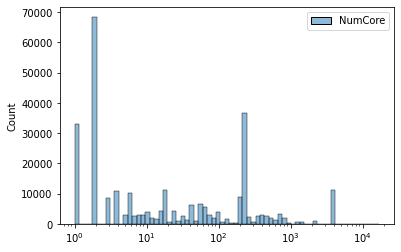

In [23]:
sns.histplot(data=df[['NumCore']].dropna(),log_scale=True)

NumCore_cut
[1.0, 2.0)          32931
[2.0, 10.0)        109661
[10.0, 100.0)       61343
[100.0, 1000.0)     69258
[1000.0, inf)       13847
dtype: int64

CategoricalDtype(categories=[[1.0, 2.0), [2.0, 10.0), [10.0, 100.0), [100.0, 1000.0), [1000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumCore_cut', ylabel='CVE+project'>

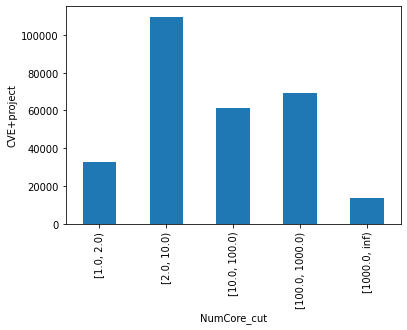

In [24]:
numcore_cut = pd.cut(df['NumCore'].dropna(),
                     bins=[1,2,10,100,1000,np.inf],right=False,include_lowest=True)
df['NumCore_cut'] = numcore_cut
display(df.value_counts('NumCore_cut').sort_index())
display(numcore_cut.dtype)

df.value_counts('NumCore_cut').sort_index().plot.bar(ylabel='CVE+project')

In [29]:
column_name='NumCore'
column_cut='NumCore_cut'
ranking_list = create_values_ranking_list(df['NumCore_cut'], df['NumCore_cut'].dtype)
ranking_list

[Interval(1.0, 2.0, closed='left'),
 Interval(2.0, 10.0, closed='left'),
 Interval(10.0, 100.0, closed='left'),
 Interval(100.0, 1000.0, closed='left'),
 Interval(1000.0, inf, closed='left')]

In [26]:
(values_hash, values_names) = values_ranking_hashes(ranking_list)

In [27]:
f_map = lambda row: f_map_generic(row, 'NumCore_cut', values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': 'NumCore_cut',
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=None)

display(ret)
display(groups)
#display(ddf)

all = 287884, selected = 287040, uncensored = 287040
Computing 50 × bootstrap Dxy for 287040 elements...
Computing confidence interval from 50 samples...
Computing descriptive statistics like mean, median, etc....


{'Cohort': 287884,
 'Number of patients': 287040.0,
 '% of cohort': 99.70682636061747,
 'Survival days, median': 366.0,
 'Survival years, median': 1.0027397260273974,
 'Dxy (full)': 0.03625522623291966,
 'bootstrap': {'Dxy': 0.036383695147691485,
  'Confidence interval low': 0.036090542865892895,
  'Confidence interval high': 0.036676847429490074,
  'confidence threshold %': 95.0,
  'bootstrap samples': 50}}

,count,median,min,25%,75%,max,mean,std,skew
NumCore_cut,,,,,,,,,
"[1.0, 2.0)",32931,337.0,0,36.0,832.5,7458,677.847924,1008.920315,2.354535
"[2.0, 10.0)",109661,506.0,0,49.0,1522.0,7205,903.683032,1023.318821,1.148198
"[10.0, 100.0)",61343,91.0,0,14.0,404.0,8019,406.046020,804.983686,3.690864
"[100.0, 1000.0)",69258,654.0,0,185.0,1323.0,7415,1033.323010,1215.519895,2.068110
"[1000.0, inf)",13847,432.0,0,105.0,1120.0,7538,931.836860,1429.453980,2.739108


In [31]:
results_summary[column_cut] = {
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

values_list = dict_keys([0, 1, 2, 3, 4])


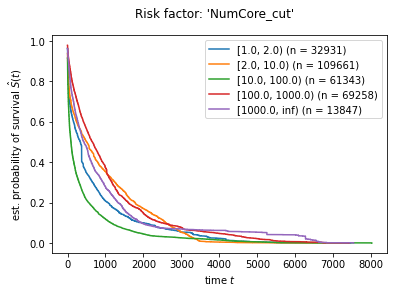

<Figure size 432x288 with 0 Axes>

In [32]:
plot_survival_function(params, ddf, condition_names=values_names)

<AxesSubplot: xlabel='Y', ylabel='NumCore_cut'>

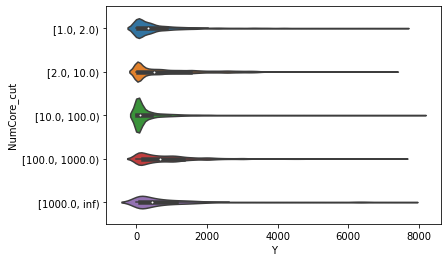

In [33]:
sns.violinplot(data=df, x="Y", y="NumCore_cut")

----

NumCore_cut2
[10.0, inf)    144448
[1.0, 10.0)    142592
dtype: int64

CategoricalDtype(categories=[[1.0, 10.0), [10.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumCore_cut2', ylabel='CVE+project'>

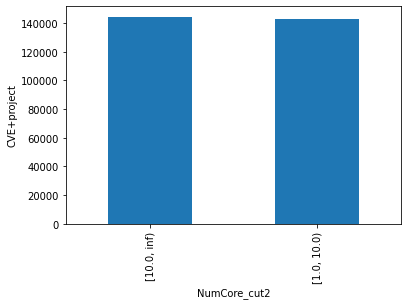

In [34]:
numcore_cut = pd.cut(df['NumCore'].dropna(),
                     bins=[1,10,np.inf],right=False,include_lowest=True)
df['NumCore_cut2'] = numcore_cut
display(df.value_counts('NumCore_cut2'))
display(numcore_cut.dtype)

df.value_counts('NumCore_cut2').plot.bar(ylabel='CVE+project')

In [35]:
ranking_list = create_values_ranking_list(df['NumCore_cut2'], df['NumCore_cut2'].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

In [36]:
f_map = lambda row: f_map_generic(row, 'NumCore_cut2', values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': 'NumCore_cut2',
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=None)

display(ret)
display(groups)
#display(ddf)

all = 287884, selected = 287040, uncensored = 287040
Computing 50 × bootstrap Dxy for 287040 elements...
Computing confidence interval from 50 samples...
Computing descriptive statistics like mean, median, etc....


{'Cohort': 287884,
 'Number of patients': 287040.0,
 '% of cohort': 99.70682636061747,
 'Survival days, median': 366.0,
 'Survival years, median': 1.0027397260273974,
 'Dxy (full)': -0.028463852673330736,
 'bootstrap': {'Dxy': -0.028314298788886166,
  'Confidence interval low': -0.028633893187174294,
  'Confidence interval high': -0.02799470439059804,
  'confidence threshold %': 95.0,
  'bootstrap samples': 50}}

,count,median,min,25%,75%,max,mean,std,skew
NumCore_cut2,,,,,,,,,
"[1.0, 10.0)",142592,408.0,0,44.0,1352.0,7458,851.527400,1024.438823,1.401776
"[10.0, inf)",144448,310.0,0,51.0,1021.0,8019,757.207514,1127.517934,2.620937


In [37]:
results_summary[column_cut] = {
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

values_list = dict_keys([0, 1])


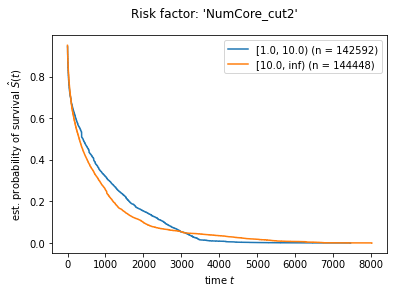

<Figure size 432x288 with 0 Axes>

In [38]:
plot_survival_function(params, ddf, condition_names=values_names)

<AxesSubplot: xlabel='Y', ylabel='NumCore_cut'>

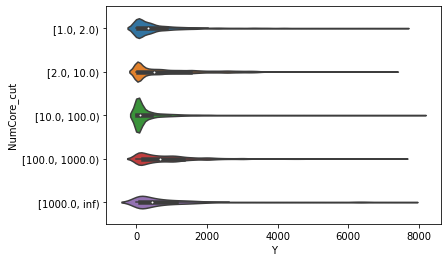

In [39]:
sns.violinplot(data=df, x="Y", y="NumCore_cut")

<AxesSubplot: xlabel='NumCore', ylabel='Y'>

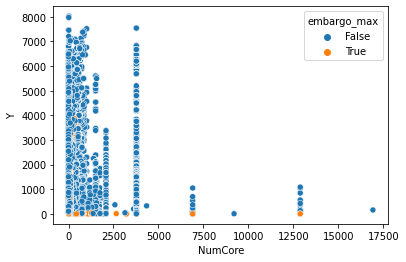

In [40]:
sns.scatterplot(data=df, x='NumCore', y='Y', hue='embargo_max')

-----
**NumAuthors**

<AxesSubplot: ylabel='Count'>

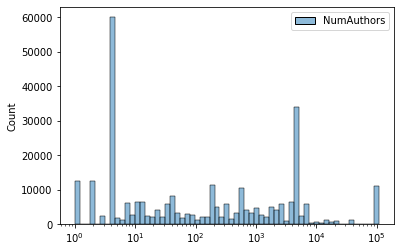

In [41]:
sns.histplot(data=df[['NumAuthors']].dropna(),log_scale=True)

NumAuthors_cut
[1.0, 4.0)         27176
[4.0, 6.0)         61922
[6.0, 100.0)       57921
[100.0, 1000.0)    51708
[1000.0, inf)      88313
dtype: int64

CategoricalDtype(categories=[[1.0, 4.0), [4.0, 6.0), [6.0, 100.0), [100.0, 1000.0), [1000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumAuthors_cut', ylabel='CVE+project'>

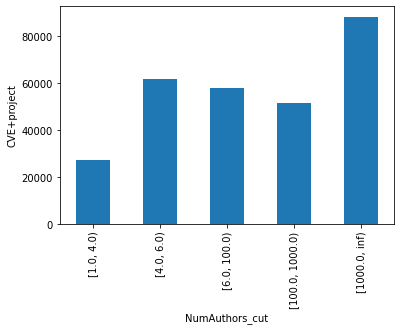

In [42]:
column_name = 'NumAuthors'
column_cut = column_name + '_cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,4,6,100,1e3,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [43]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

{0: Interval(1.0, 4.0, closed='left'),
 1: Interval(4.0, 6.0, closed='left'),
 2: Interval(6.0, 100.0, closed='left'),
 3: Interval(100.0, 1000.0, closed='left'),
 4: Interval(1000.0, inf, closed='left')}

In [44]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 287884, selected = 287040, uncensored = 287040
Computing 50 × bootstrap Dxy for 287040 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 287884,
    "Number of patients": 287040.0,
    "% of cohort": 99.70682636061747,
    "Survival days, median": 366.0,
    "Survival years, median": 1.0027397260273974,
    "Dxy (full)": -0.044496224037042786,
    "bootstrap": {
        "Dxy": -0.04427595210673235,
        "Confidence interval low": -0.044664034511142404,
        "Confidence interval high": -0.0438878697023223,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew
NumAuthors_cut,,,,,,,,,
"[1.0, 4.0)",27176,370.0,0,79.0,985.0,7458,788.010082,1074.972862,2.093759
"[4.0, 6.0)",61922,1148.0,0,503.0,2162.0,5766,1356.504651,1024.050363,0.556808
"[6.0, 100.0)",57921,50.0,0,8.0,342.0,8019,341.218660,698.598117,3.806020
"[100.0, 1000.0)",51708,83.0,0,13.0,399.0,7091,451.893227,962.478966,3.484808
"[1000.0, inf)",88313,541.0,0,134.0,1236.0,7538,931.408083,1176.590452,2.391287


In [45]:
results_summary[column_cut] = {
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

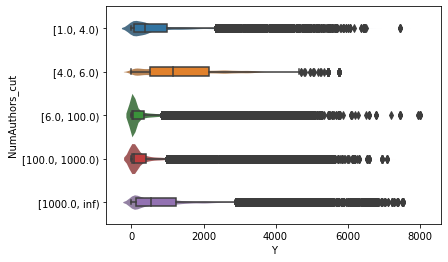

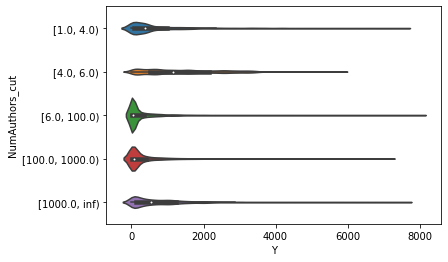

In [46]:
ax = sns.violinplot(data=df, x="Y", y=column_cut,
                    inner=None, width=1.0, linewidth=0, saturation=0.4)
sns.boxplot(data=df, x="Y", y=column_cut,
            width=0.2, boxprops={'zorder': 2}, ax=ax)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

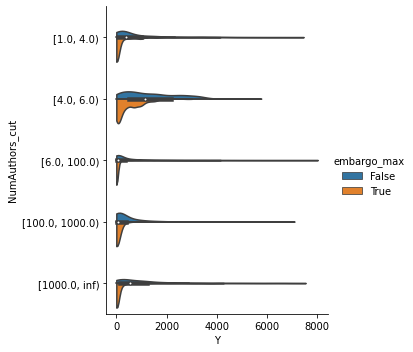

In [47]:
sns.catplot(
    data=df, x="Y", y="NumAuthors_cut", hue="embargo_max",
    kind="violin", bw=.25, cut=0, split=True,
)

{0: Interval(1.0, 4.0, closed='left'), 1: Interval(4.0, 6.0, closed='left'), 2: Interval(6.0, 100.0, closed='left'), 3: Interval(100.0, 1000.0, closed='left'), 4: Interval(1000.0, inf, closed='left')}
dict_keys([0, 1, 2, 3, 4])
values_list = dict_keys([0, 1, 2, 3, 4])


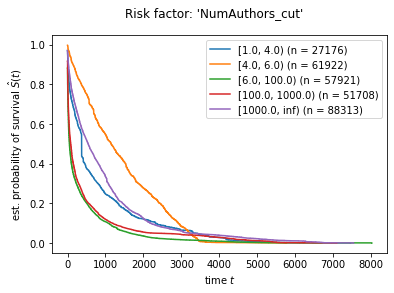

<Figure size 432x288 with 0 Axes>

In [48]:
print(values_names)
print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

<AxesSubplot: xlabel='NumAuthors', ylabel='Y'>

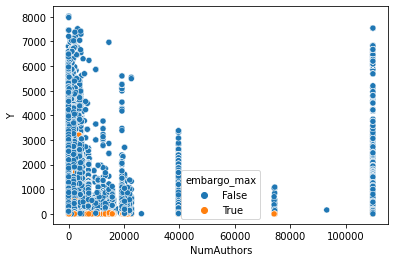

In [49]:
sns.scatterplot(data=df, x='NumAuthors', y='Y', hue='embargo_max')

### NumCore / NumAuthors

<AxesSubplot: xlabel='NumAuthors', ylabel='NumCore'>

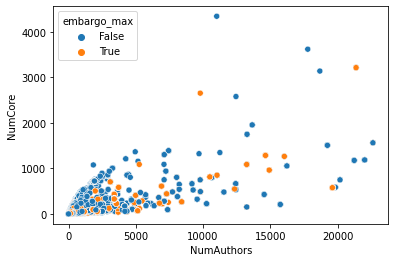

In [50]:
sns.scatterplot(data=df[df['NumAuthors']<25000], x='NumAuthors', y='NumCore', hue='embargo_max')

<AxesSubplot: xlabel='NumAuthors', ylabel='NumCore'>

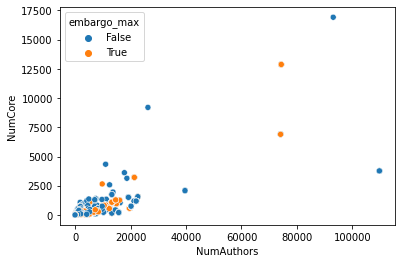

In [51]:
sns.scatterplot(data=df, x='NumAuthors', y='NumCore', hue='embargo_max')

In [52]:
df['NumCore/NumAuthors'] = df['NumCore'] / df['NumAuthors']
df['NumCore/NumAuthors'].describe()

count    287040.000000
mean          0.277194
std           0.256921
min           0.003690
25%           0.054980
50%           0.153191
75%           0.500000
max           1.000000
Name: NumCore/NumAuthors, dtype: float64

In [53]:
df['NumCore/NumAuthors'][df['NumAuthors'] > 4].describe()

count    199717.000000
mean          0.143056
std           0.136462
min           0.003690
25%           0.054980
50%           0.088670
75%           0.176471
max           0.875000
Name: NumCore/NumAuthors, dtype: float64

<AxesSubplot: ylabel='Count'>

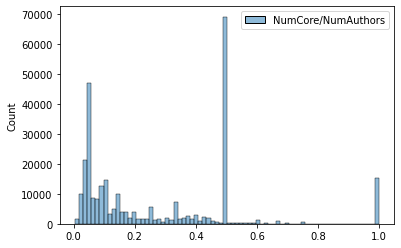

In [54]:
sns.histplot(data=df[['NumCore/NumAuthors']].dropna())

<AxesSubplot: ylabel='Count'>

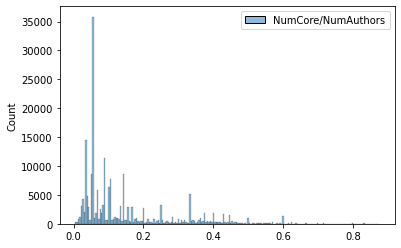

In [55]:
sns.histplot(data=df[['NumCore/NumAuthors']][df['NumAuthors']>4].dropna())

NumCore/NumAuthors cut
[0.0, 0.333)      172435
[0.333, 0.667)     97305
[0.667, 1.001)     17300
dtype: int64

CategoricalDtype(categories=[[0.0, 0.333), [0.333, 0.667), [0.667, 1.001)], ordered=True)

<AxesSubplot: xlabel='NumCore/NumAuthors cut', ylabel='CVE+project'>

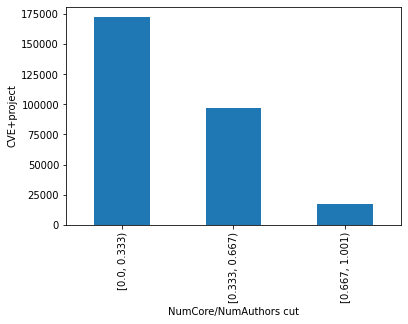

In [56]:
column_name = 'NumCore/NumAuthors'
column_cut = column_name + ' cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[0,1.0/3.0,2.0/3.0,1.001],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [57]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

{0: Interval(0.0, 0.333, closed='left'),
 1: Interval(0.333, 0.667, closed='left'),
 2: Interval(0.667, 1.001, closed='left')}

In [58]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 287884, selected = 287040, uncensored = 287040
Computing 50 × bootstrap Dxy for 287040 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 287884,
    "Number of patients": 287040.0,
    "% of cohort": 99.70682636061747,
    "Survival days, median": 366.0,
    "Survival years, median": 1.0027397260273974,
    "Dxy (full)": 0.1539970915548694,
    "bootstrap": {
        "Dxy": 0.15405253423391518,
        "Confidence interval low": 0.1538143253421708,
        "Confidence interval high": 0.15429074312565957,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew
NumCore/NumAuthors cut,,,,,,,,,
"[0.0, 0.333)",172435,182.0,0,23.0,823.0,8019,584.574454,921.179511,2.896727
"[0.333, 0.667)",97305,811.0,0,254.0,1886.0,7458,1231.282647,1222.027320,1.329581
"[0.667, 1.001)",17300,330.0,0,36.0,602.0,6512,588.846936,944.106699,2.816252


In [59]:
results_summary[column_cut] = {
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

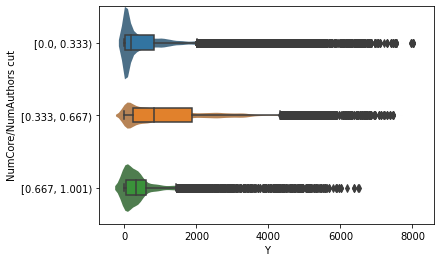

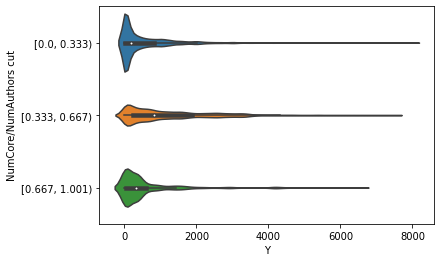

In [60]:
ax = sns.violinplot(data=df, x="Y", y=column_cut,
                    inner=None, width=1.0, linewidth=0, saturation=0.4)
sns.boxplot(data=df, x="Y", y=column_cut,
            width=0.2, boxprops={'zorder': 2}, ax=ax)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

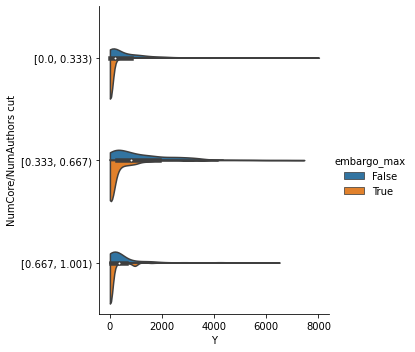

In [61]:
sns.catplot(
    data=df, x="Y", y=column_cut, hue="embargo_max",
    kind="violin", bw=.25, cut=0, split=True,
)

{0: Interval(0.0, 0.333, closed='left'), 1: Interval(0.333, 0.667, closed='left'), 2: Interval(0.667, 1.001, closed='left')}
dict_keys([0, 1, 2])
values_list = dict_keys([0, 1, 2])


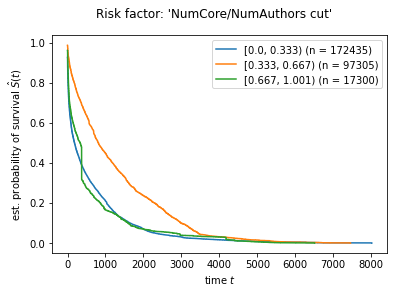

<Figure size 432x288 with 0 Axes>

In [62]:
print(values_names)
print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

<AxesSubplot: xlabel='Y', ylabel='NumCore/NumAuthors'>

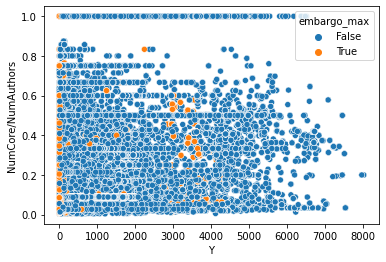

In [63]:
sns.scatterplot(data=df, y=column_name, x='Y', hue='embargo_max')

<AxesSubplot: xlabel='Y', ylabel='NumCore/NumAuthors'>

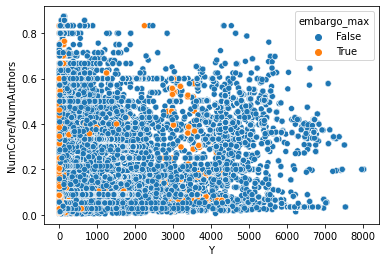

In [64]:
sns.scatterplot(data=df[df['NumAuthors']>4], y=column_name, x='Y', hue='embargo_max')

### NumCommits

<AxesSubplot: ylabel='Count'>

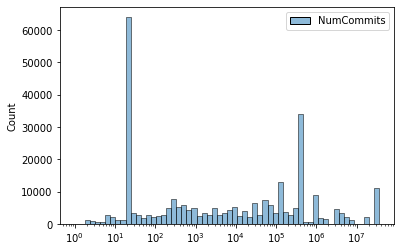

In [65]:
sns.histplot(data=df[['NumCommits']].dropna(), log_scale=True)

NumCommits_cut
[1.0, 10.0)               8039
[10.0, 100.0)            79901
[100.0, 1000.0)          38058
[1000.0, 10000.0)        26662
[10000.0, 100000.0)      37810
[100000.0, 1000000.0)    68728
[1000000.0, inf)         28397
dtype: int64

CategoricalDtype(categories=[[1.0, 10.0), [10.0, 100.0), [100.0, 1000.0), [1000.0, 10000.0), [10000.0, 100000.0), [100000.0, 1000000.0), [1000000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumCommits_cut', ylabel='CVE+project'>

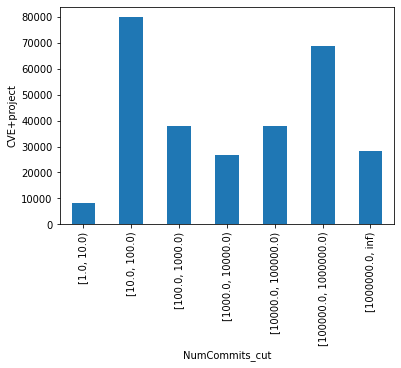

In [66]:
column_name = 'NumCommits'
column_cut = column_name + '_cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,10,100,1000,10000,100000,1000000,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

all = 287884, selected = 287595, uncensored = 287595
Computing 50 × bootstrap Dxy for 287595 elements...
Computing confidence interval from 50 samples...
Computing descriptive statistics like mean, median, etc....


{'Cohort': 287884,
 'Number of patients': 287595.0,
 '% of cohort': 99.89961234386072,
 'Survival days, median': 368.0,
 'Survival years, median': 1.0082191780821919,
 'Dxy (full)': -0.12490779757162362,
 'bootstrap': {'Dxy': -0.12479248665780783,
  'Confidence interval low': -0.12511000596484145,
  'Confidence interval high': -0.1244749673507742,
  'confidence threshold %': 95.0,
  'bootstrap samples': 50}}

,count,median,min,25%,75%,max,mean,std,skew
NumCommits_cut,,,,,,,,,
"[1.0, 10.0)",8039,370.0,0,215.0,928.0,6026,828.598582,1110.999562,2.213152
"[10.0, 100.0)",79901,916.0,0,309.0,1922.0,6800,1207.258758,1046.564570,0.764288
"[100.0, 1000.0)",38058,102.0,0,17.0,616.0,7458,513.431841,934.449996,3.096977
"[1000.0, 10000.0)",26662,237.0,0,34.0,792.0,8019,900.237079,1537.328254,2.158111
"[10000.0, 100000.0)",37810,49.0,0,4.0,254.0,7512,350.990003,865.093109,4.411390
"[100000.0, 1000000.0)",68728,497.0,0,84.0,1200.0,7043,798.252663,878.260982,1.539252
"[1000000.0, inf)",28397,179.0,0,38.0,667.0,7538,587.219354,1100.336966,3.741667


values_list = dict_keys([0, 1, 2, 3, 4, 5, 6])


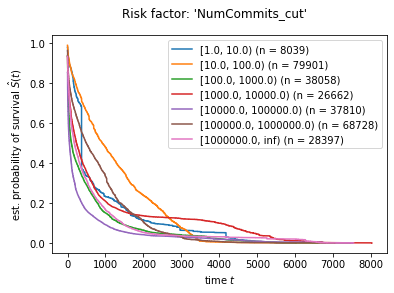

<Figure size 432x288 with 0 Axes>

In [67]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=None)

display(ret)
display(groups)
#display(ddf)

plot_survival_function(params, ddf, condition_names=values_names)

In [68]:
results_summary[column_cut] = {
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

<AxesSubplot: xlabel='Y', ylabel='NumCommits_cut'>

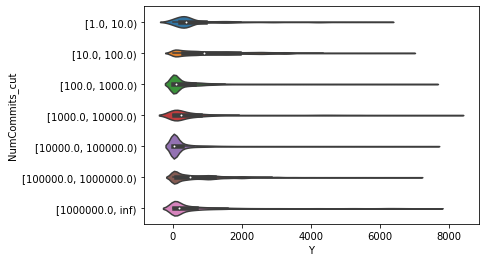

In [69]:
sns.violinplot(data=df, x="Y", y="NumCommits_cut")

NumCommits_cut2
[1.0, 100.0)          87940
[100.0, 100000.0)    102530
[100000.0, inf)       97125
dtype: int64

CategoricalDtype(categories=[[1.0, 100.0), [100.0, 100000.0), [100000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumCommits_cut2', ylabel='CVE+project'>

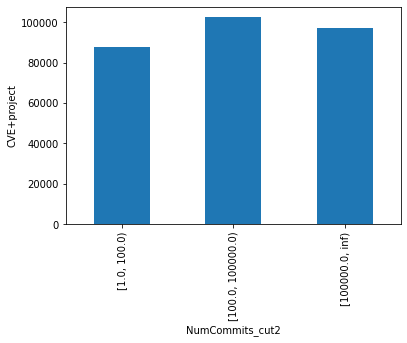

In [70]:
column_name = 'NumCommits'
column_cut = column_name + '_cut2'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,100,100000,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

all = 287884, selected = 287595, uncensored = 287595
Computing 50 × bootstrap Dxy for 287595 elements...
Computing confidence interval from 50 samples...
Computing descriptive statistics like mean, median, etc....


{'Cohort': 287884,
 'Number of patients': 287595.0,
 '% of cohort': 99.89961234386072,
 'Survival days, median': 368.0,
 'Survival years, median': 1.0082191780821919,
 'Dxy (full)': -0.10734577152973523,
 'bootstrap': {'Dxy': -0.1073728260704474,
  'Confidence interval low': -0.10770897430865234,
  'Confidence interval high': -0.10703667783224247,
  'confidence threshold %': 95.0,
  'bootstrap samples': 50}}

,count,median,min,25%,75%,max,mean,std,skew
NumCommits_cut2,,,,,,,,,
"[1.0, 100.0)",87940,829.0,0,290.75,1828.00,6800,1172.643689,1058.25398,0.891513
"[100.0, 100000.0)",102530,98.0,0,13.00,534.75,8019,554.113352,1123.22515,3.152937
"[100000.0, inf)",97125,372.0,0,60.00,1081.00,7538,736.551629,953.42274,2.465530


values_list = dict_keys([0, 1, 2])


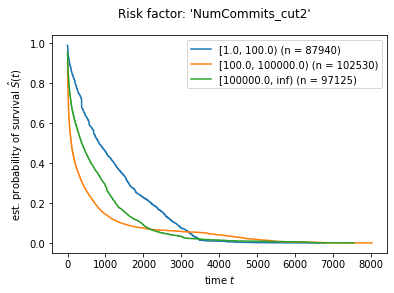

<Figure size 432x288 with 0 Axes>

In [71]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=None)

display(ret)
display(groups)
#display(ddf)

plot_survival_function(params, ddf, condition_names=values_names)

In [72]:
results_summary[column_cut] = {
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

<AxesSubplot: xlabel='Y', ylabel='NumCommits_cut2'>

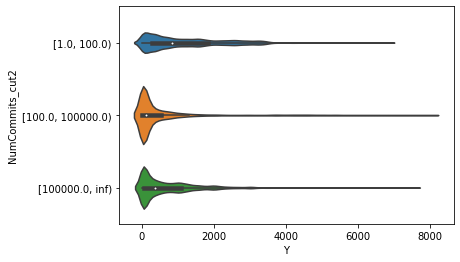

In [73]:
sns.violinplot(data=df, x="Y", y="NumCommits_cut2")

<AxesSubplot: xlabel='NumCommits', ylabel='Y'>

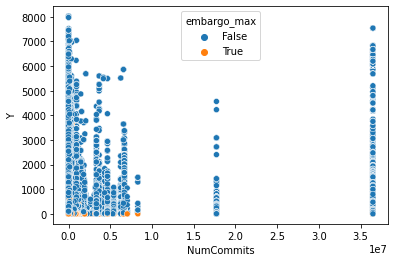

In [74]:
sns.scatterplot(data=df, x='NumCommits', y='Y', hue='embargo_max')

### NumMon and ActiveMon \[%]

In [75]:
df['CommitDateRange']=df['LatestCommitDate']-df['EarliestCommitDate']
df['CommitDateRange [days]']=df['CommitDateRange'].dt.days
df['CommitDateRange [mon]']=\
12 * (df['LatestCommitDate'].dt.year  - df['EarliestCommitDate'].dt.year) +\
     (df['LatestCommitDate'].dt.month - df['EarliestCommitDate'].dt.month)

df[['CommitDateRange [days]', 'CommitDateRange [mon]']].describe()

,CommitDateRange [days],CommitDateRange [mon]
count,287884.000000,287884.000000
mean,5922.436388,194.552483
std,7695.629069,252.751002
min,0.000000,0.000000
25%,1120.000000,37.000000
50%,3304.000000,108.000000
75%,7863.000000,258.000000
max,81273.000000,2671.000000


<AxesSubplot: xlabel='CommitDateRange [days]', ylabel='NumActiveMon'>

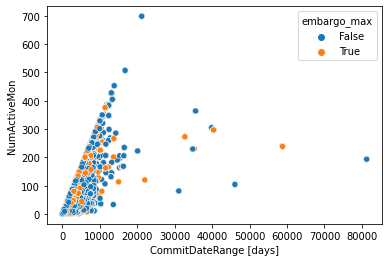

In [76]:
sns.scatterplot(data=df, x='CommitDateRange [days]', y='NumActiveMon', hue='embargo_max')

<AxesSubplot: xlabel='CommitDateRange [days]', ylabel='CommitDateRange [mon]'>

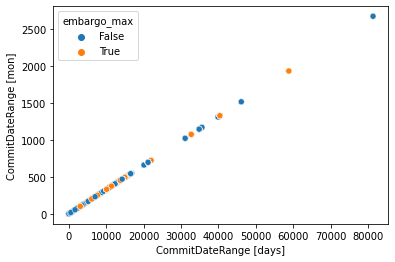

In [77]:
sns.scatterplot(data=df, x='CommitDateRange [days]', y='CommitDateRange [mon]', hue='embargo_max')

In [78]:
df['NumActiveMon [%]']=100.0*df['NumActiveMon']/(df['CommitDateRange [mon]']+1)
df[['NumActiveMon [%]']].describe()

,NumActiveMon [%]
count,287884.000000
mean,66.845038
std,30.128085
min,1.379310
25%,34.210526
50%,72.058824
75%,100.000000
max,200.000000


<AxesSubplot: ylabel='Count'>

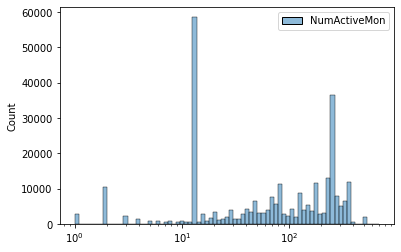

In [79]:
sns.histplot(data=df[['NumActiveMon']].dropna(), log_scale=True)

<AxesSubplot: ylabel='Count'>

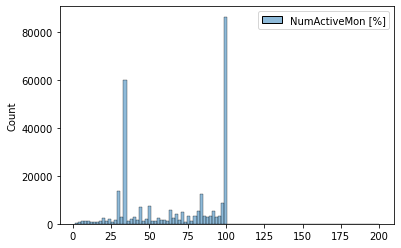

In [80]:
sns.histplot(data=df[['NumActiveMon [%]']].dropna())

NumActiveMon [%] cut
[-0.1, 25.0)      13402
[25.0, 50.0)      99463
[50.0, 75.0)      34007
[75.0, 100.0)     67358
[100.0, 200.0)    73652
dtype: int64

CategoricalDtype(categories=[[-0.1, 25.0), [25.0, 50.0), [50.0, 75.0), [75.0, 100.0), [100.0, 200.0)], ordered=True)

<AxesSubplot: xlabel='NumActiveMon [%] cut', ylabel='CVE+project'>

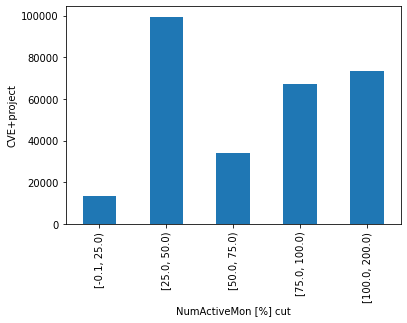

In [81]:
column_name = 'NumActiveMon [%]'
column_cut = column_name + ' cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[-0.1,25,50,75,100,200],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

all = 287884, selected = 287882, uncensored = 287882
Computing 50 × bootstrap Dxy for 287882 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 287884,
    "Number of patients": 287882.0,
    "% of cohort": 99.99930527573606,
    "Survival days, median": 368.0,
    "Survival years, median": 1.0082191780821919,
    "Dxy (full)": -0.13227391536535205,
    "bootstrap": {
        "Dxy": -0.13219453692823085,
        "Confidence interval low": -0.132584121318013,
        "Confidence interval high": -0.1318049525384487,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew
NumActiveMon [%] cut,,,,,,,,,
"[-0.1, 25.0)",13402,370.0,0,72.0,566.0,7043,579.130951,879.746110,3.245294
"[25.0, 50.0)",99463,759.0,0,220.0,1754.0,7538,1167.967485,1211.395349,1.575770
"[50.0, 75.0)",34007,237.0,0,30.0,832.0,7512,711.316082,1121.261041,2.339167
"[75.0, 100.0)",67358,107.0,0,19.0,488.0,7458,479.946450,936.004844,3.426222
"[100.0, 200.0)",73652,321.0,0,27.0,1099.0,8019,696.451515,867.539563,1.674168


values_list = dict_keys([0, 1, 2, 3, 4])


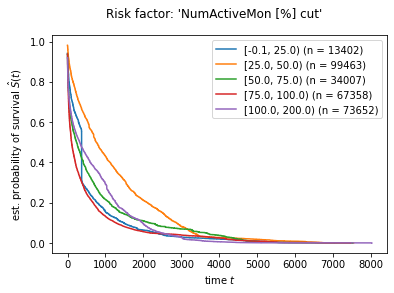

<Figure size 432x288 with 0 Axes>

In [82]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=None)

print(json.dumps(ret, indent=4))
display(groups)
#display(ddf)

plot_survival_function(params, ddf, condition_names=values_names)

In [83]:
results_summary[column_cut] = {
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

<AxesSubplot: xlabel='Y', ylabel='NumActiveMon [%] cut'>

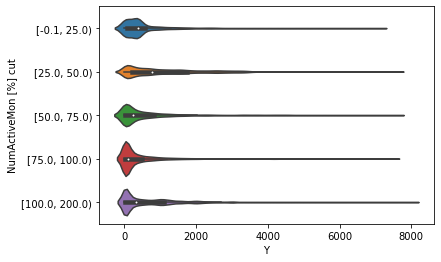

In [84]:
sns.violinplot(data=df, x="Y", y="NumActiveMon [%] cut")

<AxesSubplot: xlabel='NumActiveMon [%]', ylabel='Y'>

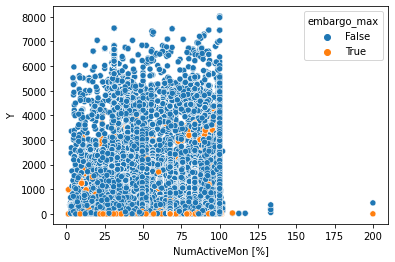

In [85]:
sns.scatterplot(data=df, x='NumActiveMon [%]', y='Y', hue='embargo_max')

NumActiveMon_cut
[1, 10)         20943
[10, 100)      137547
[100, 1000)    129394
dtype: int64

CategoricalDtype(categories=[[1, 10), [10, 100), [100, 1000)], ordered=True)

<AxesSubplot: xlabel='NumActiveMon_cut', ylabel='CVE+project'>

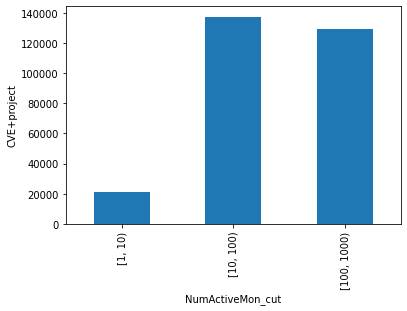

In [86]:
column_name = 'NumActiveMon'
column_cut = column_name + '_cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,10,100,1000],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [87]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

print(values_names)

{0: Interval(1, 10, closed='left'), 1: Interval(10, 100, closed='left'), 2: Interval(100, 1000, closed='left')}


all = 287884, selected = 287884, uncensored = 287884
Computing 50 × bootstrap Dxy for 287884 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 287884,
    "Number of patients": 287884.0,
    "% of cohort": 100.0,
    "Survival days, median": 368.0,
    "Survival years, median": 1.0082191780821919,
    "Dxy (full)": -0.09865773293809288,
    "bootstrap": {
        "Dxy": -0.09858696990219715,
        "Confidence interval low": -0.09892438839115605,
        "Confidence interval high": -0.09824955141323824,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew
NumActiveMon_cut,,,,,,,,,
"[1, 10)",20943,370.0,0,193.0,1232.0,6437,859.547486,1052.093076,1.911105
"[10, 100)",137547,506.0,0,76.0,1447.0,8019,966.271347,1194.099289,1.728183
"[100, 1000)",129394,224.0,0,25.0,956.0,7538,624.722097,915.500059,2.672974


values_list = dict_keys([0, 1, 2])


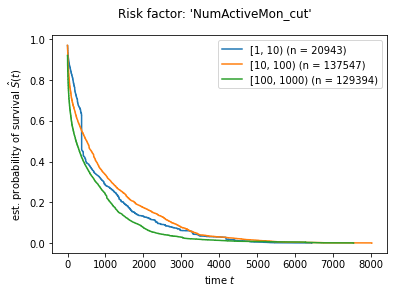

<Figure size 432x288 with 0 Axes>

In [88]:
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=None)

print(json.dumps(ret, indent=4))
display(groups)
#display(ddf)

plot_survival_function(params, ddf, condition_names=values_names)

In [89]:
results_summary[column_cut] = {
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

<AxesSubplot: xlabel='Y', ylabel='NumActiveMon_cut'>

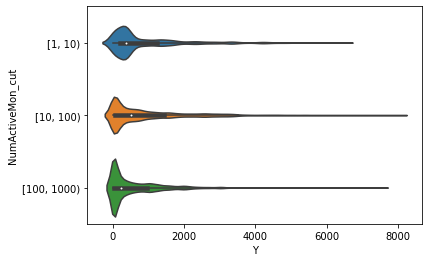

In [90]:
sns.violinplot(data=df, x="Y", y="NumActiveMon_cut")

<AxesSubplot: xlabel='NumActiveMon', ylabel='Y'>

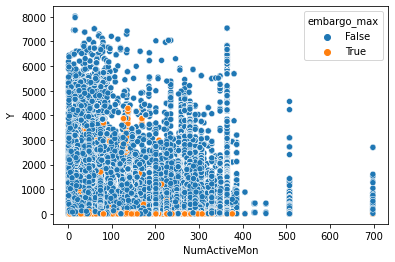

In [91]:
sns.scatterplot(data=df, x='NumActiveMon', y='Y', hue='embargo_max')

-----
**CommitDateRange \[days]**

In [92]:
column_name='CommitDateRange [days]'

In [93]:
df['CommitDateRange [days]'].describe()

count    287884.000000
mean       5922.436388
std        7695.629069
min           0.000000
25%        1120.000000
50%        3304.000000
75%        7863.000000
max       81273.000000
Name: CommitDateRange [days], dtype: float64

<AxesSubplot: ylabel='Count'>

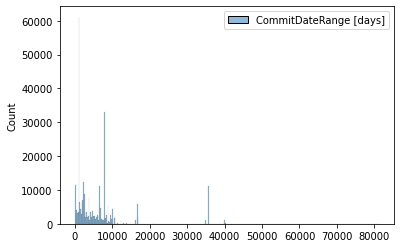

In [94]:
column_name='CommitDateRange [days]'
sns.histplot(data=df[[column_name]].dropna())

<AxesSubplot: ylabel='Count'>

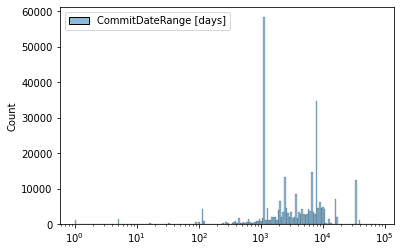

In [95]:
column_name='CommitDateRange [days]'
sns.histplot(data=df[[column_name]].dropna()+1, log_scale=True)

CommitDateRange [days] cut
[0.0, 30.0)            3669
[30.0, 365.0)          9716
[365.0, 1000.0)       11755
[1000.0, 5000.0)     143004
[5000.0, 10000.0)     86040
[10000.0, inf)        33700
dtype: int64

CategoricalDtype(categories=[[0.0, 30.0), [30.0, 365.0), [365.0, 1000.0), [1000.0, 5000.0), [5000.0, 10000.0), [10000.0, inf)], ordered=True)

<AxesSubplot: xlabel='CommitDateRange [days] cut', ylabel='CVE+project'>

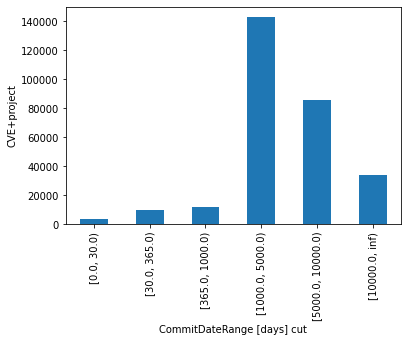

In [96]:
column_name = 'CommitDateRange [days]'
column_cut = column_name + ' cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[0,30,365,1e3,5e3,1e4,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [97]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

{0: Interval(0.0, 30.0, closed='left'),
 1: Interval(30.0, 365.0, closed='left'),
 2: Interval(365.0, 1000.0, closed='left'),
 3: Interval(1000.0, 5000.0, closed='left'),
 4: Interval(5000.0, 10000.0, closed='left'),
 5: Interval(10000.0, inf, closed='left')}

In [98]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 287884, selected = 287884, uncensored = 287884
Computing 50 × bootstrap Dxy for 287884 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 287884,
    "Number of patients": 287884.0,
    "% of cohort": 100.0,
    "Survival days, median": 368.0,
    "Survival years, median": 1.0082191780821919,
    "Dxy (full)": -0.04169731929231424,
    "bootstrap": {
        "Dxy": -0.04168894671218945,
        "Confidence interval low": -0.041949142939316134,
        "Confidence interval high": -0.04142875048506277,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew
CommitDateRange [days] cut,,,,,,,,,
"[0.0, 30.0)",3669,256.0,0,83.0,694.0,6176,524.346416,733.041981,2.985129
"[30.0, 365.0)",9716,705.0,0,259.0,1773.0,6437,1222.483121,1232.360512,1.218791
"[365.0, 1000.0)",11755,309.0,0,47.0,601.0,8019,697.824840,1131.040775,2.470012
"[1000.0, 5000.0)",143004,370.0,0,45.0,1247.0,7512,848.007300,1090.923412,1.705489
"[5000.0, 10000.0)",86040,466.0,0,50.0,1197.0,7415,817.776732,1028.430309,2.226097
"[10000.0, inf)",33700,172.0,0,37.0,524.0,7538,537.393739,1059.615540,3.893280


In [99]:
results_summary[column_cut] = {
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

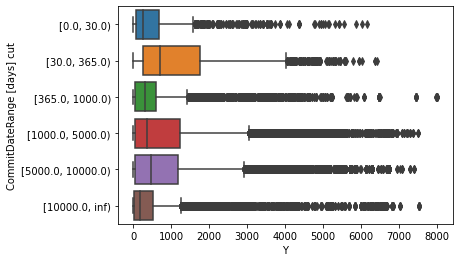

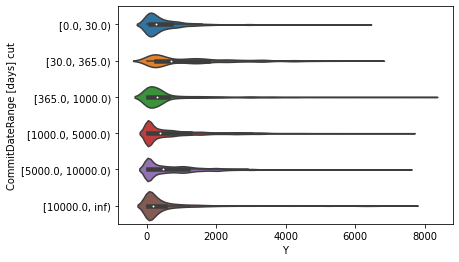

In [100]:
sns.boxplot(data=df, x="Y", y=column_cut)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

{0: Interval(0.0, 30.0, closed='left'), 1: Interval(30.0, 365.0, closed='left'), 2: Interval(365.0, 1000.0, closed='left'), 3: Interval(1000.0, 5000.0, closed='left'), 4: Interval(5000.0, 10000.0, closed='left'), 5: Interval(10000.0, inf, closed='left')}
dict_keys([0, 1, 2, 3, 4, 5])
values_list = dict_keys([0, 1, 2, 3, 4, 5])


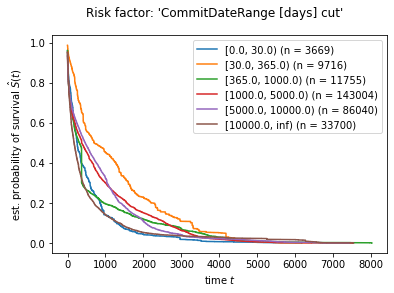

<Figure size 432x288 with 0 Axes>

In [101]:
print(values_names)
print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

<AxesSubplot: xlabel='CommitDateRange [days]', ylabel='Y'>

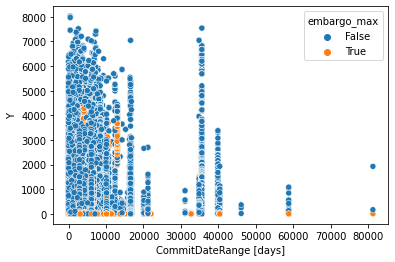

In [102]:
sns.scatterplot(data=df, x=column_name, y='Y', hue='embargo_max')

<AxesSubplot: xlabel='CommitDateRange [days]', ylabel='Y'>

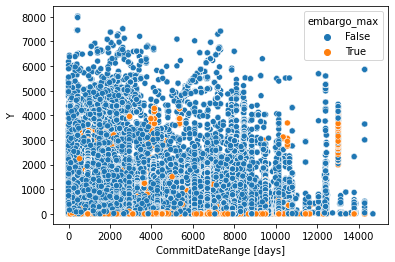

In [103]:
sns.scatterplot(data=df[df[column_name]<15000], x=column_name, y='Y', hue='embargo_max')

### Popularity: NumStars

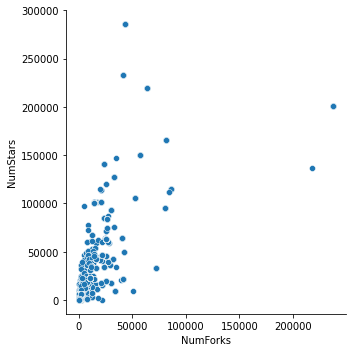

In [104]:
sns.relplot(df[['NumForks','NumStars']].dropna(),x='NumForks',y='NumStars')
plt.show()

<AxesSubplot: ylabel='Count'>

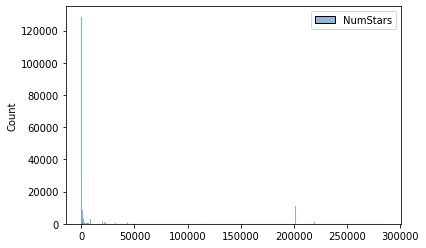

<AxesSubplot: ylabel='Count'>

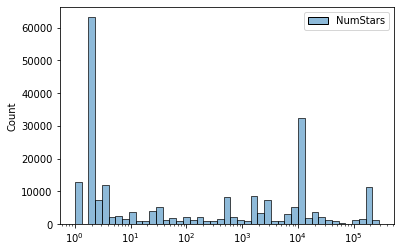

In [105]:
sns.histplot(data=df[['NumStars']].dropna())
plt.show()
sns.histplot(data=df[['NumStars']].dropna(), log_scale=True)
plt.show()

NumStars_cut
[1.0, 2.0)             12804
[2.0, 5.0)             82631
[5.0, 10.0)             5991
[10.0, 100.0)          19064
[100.0, 1000.0)        20020
[1000.0, 10000.0)      30327
[10000.0, 100000.0)    42526
[100000.0, inf)        14806
dtype: int64

CategoricalDtype(categories=[[1.0, 2.0), [2.0, 5.0), [5.0, 10.0), [10.0, 100.0), [100.0, 1000.0), [1000.0, 10000.0), [10000.0, 100000.0), [100000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumStars_cut', ylabel='CVE+project'>

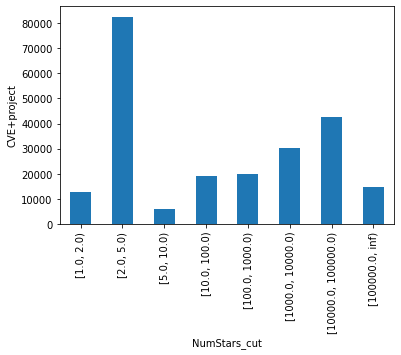

In [106]:
column_name = 'NumStars'
column_cut = column_name + '_cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,2,5,10,100,1000,10000,100000,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

NumStars_cut
[1.0, 3.0)          76052
[3.0, 100.0)        44438
[100.0, 10000.0)    50347
[10000.0, inf)      57332
dtype: int64

CategoricalDtype(categories=[[1.0, 3.0), [3.0, 100.0), [100.0, 10000.0), [10000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumStars_cut', ylabel='CVE+project'>

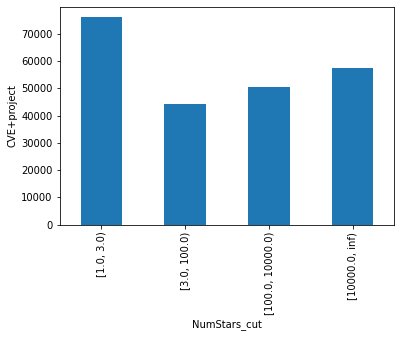

In [107]:
column_name = 'NumStars'
column_cut = column_name + '_cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,3,100,10000,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

all = 287884, selected = 228169, uncensored = 228169
Computing 50 × bootstrap Dxy for 228169 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 287884,
    "Number of patients": 228169.0,
    "% of cohort": 79.25727028942212,
    "Survival days, median": 441.0,
    "Survival years, median": 1.2082191780821918,
    "Dxy (full)": -0.07467617618027633,
    "bootstrap": {
        "Dxy": -0.07478949692234718,
        "Confidence interval low": -0.07512175061027802,
        "Confidence interval high": -0.07445724323441634,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew
NumStars_cut,,,,,,,,,
"[1.0, 3.0)",76052,917.0,0,282.0,1964.0,7225,1237.157524,1115.165349,0.973089
"[3.0, 100.0)",44438,166.0,0,24.0,705.0,8019,605.974301,1090.028504,3.101296
"[100.0, 10000.0)",50347,95.0,0,19.0,291.0,7205,301.771466,638.152757,4.769006
"[10000.0, inf)",57332,824.5,0,268.0,1427.5,7538,1021.521646,1028.358938,2.135581


values_list = dict_keys([0, 1, 2, 3])


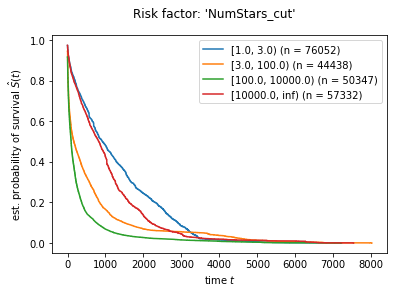

<Figure size 432x288 with 0 Axes>

In [108]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=None)

print(json.dumps(ret, indent=4))
display(groups)
#display(ddf)

plot_survival_function(params, ddf, condition_names=values_names)

In [109]:
results_summary[column_cut] = {
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

<AxesSubplot: xlabel='Y', ylabel='NumStars_cut'>

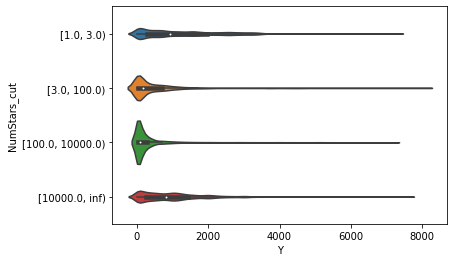

In [110]:
sns.violinplot(data=df, x="Y", y="NumStars_cut")

In [113]:
df_mask = df['NumStars'] < 10000
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)
#display(ddf)

#plot_survival_function(params, ddf, condition_names=values_names)

all = 287884, selected = 170837, uncensored = 170837
Computing 50 × bootstrap Dxy for 170837 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 287884,
    "Number of patients": 170837.0,
    "% of cohort": 59.34230453932834,
    "Survival days, median": 326.0,
    "Survival years, median": 0.8931506849315068,
    "Dxy (full)": -0.28690061150660207,
    "bootstrap": {
        "Dxy": -0.28681114139716324,
        "Confidence interval low": -0.28720217528768327,
        "Confidence interval high": -0.2864201075066432,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew
NumStars_cut,,,,,,,,,
"[1.0, 3.0)",76052,917.0,0,282.0,1964.0,7225,1237.157524,1115.165349,0.973089
"[3.0, 100.0)",44438,166.0,0,24.0,705.0,8019,605.974301,1090.028504,3.101296
"[100.0, 10000.0)",50347,95.0,0,19.0,291.0,7205,301.771466,638.152757,4.769006


In [115]:
results_summary[f"{column_cut}+NumStars<10000"] = {
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

<AxesSubplot: xlabel='NumStars', ylabel='Y'>

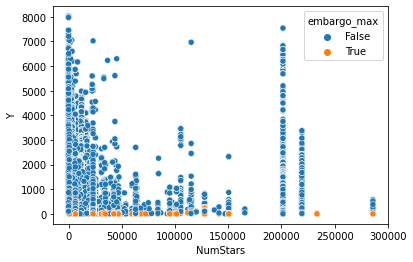

In [116]:
sns.scatterplot(data=df, x='NumStars', y='Y', hue='embargo_max')

-----
**NumForks**

In [117]:
df.columns

Index(['commit_cves', 'project_names', 'commits', 'used_dep_manager',
       'cve_lifespan_commiter_time', 'cve_lifespan_author_time', 'embargo_min',
       'embargo_max', 'lang_Shell', 'other_languages', 'variable', 'value',
       'programming_paradigm', 'Programming paradigm', 'compilation_class',
       'Compilation class', 'type_class', 'Type class', 'memory_model',
       'Memory model', 'extended_programming_paradigm',
       'Programming paradigm (extended)', 'cve', 'cvss', 'cwe', 'cvss-vector',
       'access.authentication', 'access.complexity', 'access.vector',
       'impact.availability', 'impact.confidentiality', 'impact.integrity',
       'CVSS v2.0 Ratings', 'CVSS v3.1 Ratings', 'RootFork',
       'EarliestCommitDate', 'LatestCommitDate', 'NumActiveMon', 'NumAuthors',
       'NumCore', 'CommunitySize', 'NumCommits', 'NumBlobs', 'NumFiles',
       'NumForks', 'NumStars', 'E', 'Y', 'NumCore_cut', 'NumCore_cut2',
       'NumAuthors_cut', 'NumCore/NumAuthors', 'NumCore/NumA

In [118]:
df[['NumForks','NumStars']].describe()

,NumForks,NumStars
count,287876.000000,228169.000000
mean,11131.559810,15738.112057
std,45994.074477,46962.572570
min,0.000000,1.000000
25%,0.000000,2.000000
50%,5.000000,35.000000
75%,1340.000000,11954.000000
max,237104.000000,285958.000000


<AxesSubplot: ylabel='Count'>

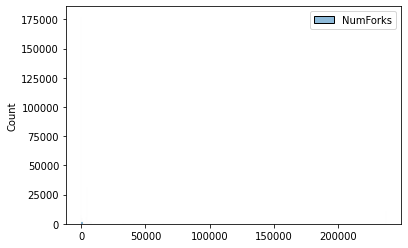

<AxesSubplot: ylabel='Count'>

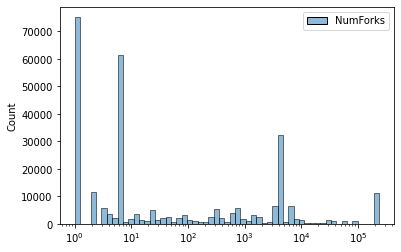

In [119]:
sns.histplot(data=df[['NumForks']].dropna())
plt.show()
sns.histplot(data=df[['NumForks']].dropna()+1, log_scale=True)
plt.show()

NumForks_cut
[0.0, 1.0)        75290
[1.0, 5.0)        23038
[5.0, 10.0)       64271
[10.0, 1000.0)    50246
[1000.0, inf)     75031
dtype: int64

CategoricalDtype(categories=[[0.0, 1.0), [1.0, 5.0), [5.0, 10.0), [10.0, 1000.0), [1000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumForks_cut', ylabel='CVE+project'>

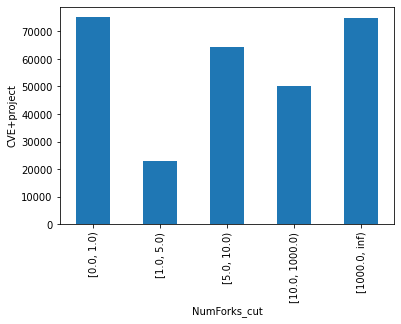

In [120]:
column_name = 'NumForks'
column_cut = column_name + '_cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[0,1,5,10,1e3,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [121]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

{0: Interval(0.0, 1.0, closed='left'),
 1: Interval(1.0, 5.0, closed='left'),
 2: Interval(5.0, 10.0, closed='left'),
 3: Interval(10.0, 1000.0, closed='left'),
 4: Interval(1000.0, inf, closed='left')}

In [122]:
df.columns

Index(['commit_cves', 'project_names', 'commits', 'used_dep_manager',
       'cve_lifespan_commiter_time', 'cve_lifespan_author_time', 'embargo_min',
       'embargo_max', 'lang_Shell', 'other_languages', 'variable', 'value',
       'programming_paradigm', 'Programming paradigm', 'compilation_class',
       'Compilation class', 'type_class', 'Type class', 'memory_model',
       'Memory model', 'extended_programming_paradigm',
       'Programming paradigm (extended)', 'cve', 'cvss', 'cwe', 'cvss-vector',
       'access.authentication', 'access.complexity', 'access.vector',
       'impact.availability', 'impact.confidentiality', 'impact.integrity',
       'CVSS v2.0 Ratings', 'CVSS v3.1 Ratings', 'RootFork',
       'EarliestCommitDate', 'LatestCommitDate', 'NumActiveMon', 'NumAuthors',
       'NumCore', 'CommunitySize', 'NumCommits', 'NumBlobs', 'NumFiles',
       'NumForks', 'NumStars', 'E', 'Y', 'NumCore_cut', 'NumCore_cut2',
       'NumAuthors_cut', 'NumCore/NumAuthors', 'NumCore/NumA

In [123]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 287884, selected = 287876, uncensored = 287876
Computing 50 × bootstrap Dxy for 287876 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 287884,
    "Number of patients": 287876.0,
    "% of cohort": 99.99722110294424,
    "Survival days, median": 368.0,
    "Survival years, median": 1.0082191780821919,
    "Dxy (full)": 0.08028561567678683,
    "bootstrap": {
        "Dxy": 0.0802099298347202,
        "Confidence interval low": 0.07985583642295954,
        "Confidence interval high": 0.08056402324648085,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew
NumForks_cut,,,,,,,,,
"[0.0, 1.0)",75290,102.0,0,12.0,638.0,8019,571.108075,1040.664627,2.865528
"[1.0, 5.0)",23038,370.0,0,37.0,693.0,7458,743.721590,1260.925737,2.559861
"[5.0, 10.0)",64271,1128.0,0,467.5,2160.0,7091,1359.900639,1077.008877,0.806548
"[10.0, 1000.0)",50246,96.0,0,17.0,419.0,7205,410.038431,857.375294,4.029569
"[1000.0, inf)",75031,533.0,0,118.0,1218.0,7538,847.726940,992.950419,2.315068


In [124]:
results_summary[column_cut] = {
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

<AxesSubplot: xlabel='Y', ylabel='NumForks_cut'>

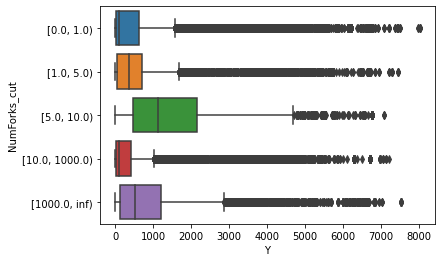

In [125]:
sns.boxplot(data=df, x="Y", y="NumForks_cut")

<AxesSubplot: xlabel='Y', ylabel='NumForks_cut'>

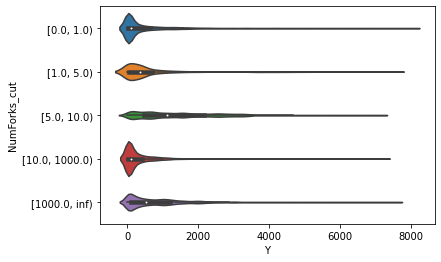

In [126]:
sns.violinplot(data=df, x="Y", y="NumForks_cut")

{0: Interval(0.0, 1.0, closed='left'), 1: Interval(1.0, 5.0, closed='left'), 2: Interval(5.0, 10.0, closed='left'), 3: Interval(10.0, 1000.0, closed='left'), 4: Interval(1000.0, inf, closed='left')}
dict_keys([0, 1, 2, 3, 4])
values_list = dict_keys([0, 1, 2, 3, 4])


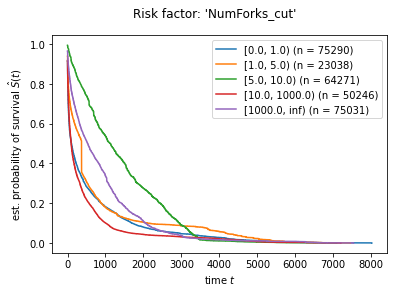

<Figure size 432x288 with 0 Axes>

In [127]:
print(values_names)
print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

<AxesSubplot: xlabel='NumForks', ylabel='Y'>

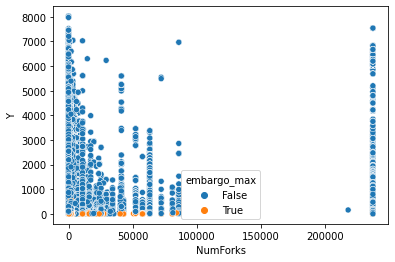

In [128]:
sns.scatterplot(data=df, x='NumForks', y='Y', hue='embargo_max')

----
**CommunitySize** (shared commits?)

In [129]:
df['CommunitySize'].describe()

count    287876.000000
mean       6339.450840
std       22615.227119
min           1.000000
25%           2.000000
50%           6.000000
75%        1184.000000
max      154323.000000
Name: CommunitySize, dtype: float64

<AxesSubplot: ylabel='Count'>

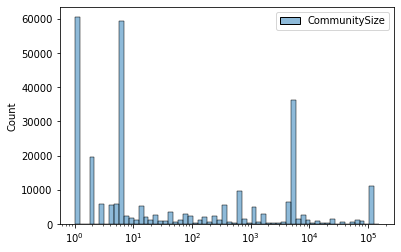

In [130]:
#sns.histplot(data=df[['CommunitySize']].dropna())
#plt.show()
sns.histplot(data=df[['CommunitySize']].dropna(), log_scale=True)
plt.show()

CommunitySize_cut
[1.0, 2.0)        60561
[2.0, 6.0)        36583
[6.0, 10.0)       62725
[10.0, 1000.0)    51329
[1000.0, inf)     76678
dtype: int64

CategoricalDtype(categories=[[1.0, 2.0), [2.0, 6.0), [6.0, 10.0), [10.0, 1000.0), [1000.0, inf)], ordered=True)

<AxesSubplot: xlabel='CommunitySize_cut', ylabel='CVE+project'>

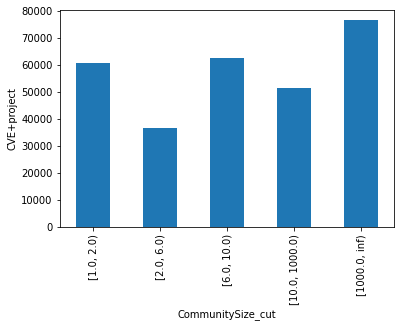

In [131]:
column_name = 'CommunitySize'
column_cut = column_name + '_cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,2,6,10,1e3,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [132]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

{0: Interval(1.0, 2.0, closed='left'),
 1: Interval(2.0, 6.0, closed='left'),
 2: Interval(6.0, 10.0, closed='left'),
 3: Interval(10.0, 1000.0, closed='left'),
 4: Interval(1000.0, inf, closed='left')}

In [133]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 287884, selected = 287876, uncensored = 287876
Computing 50 × bootstrap Dxy for 287876 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 287884,
    "Number of patients": 287876.0,
    "% of cohort": 99.99722110294424,
    "Survival days, median": 368.0,
    "Survival years, median": 1.0082191780821919,
    "Dxy (full)": 0.07103163788764322,
    "bootstrap": {
        "Dxy": 0.07107189904202149,
        "Confidence interval low": 0.07078749497345382,
        "Confidence interval high": 0.07135630311058916,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew
CommunitySize_cut,,,,,,,,,
"[1.0, 2.0)",60561,86.0,0,12.0,595.0,7512,532.892654,1013.620750,3.086720
"[2.0, 6.0)",36583,369.0,0,32.0,823.0,7458,766.300549,1223.443591,2.463668
"[6.0, 10.0)",62725,1144.0,0,506.0,2191.0,7091,1374.843874,1061.513452,0.736528
"[10.0, 1000.0)",51329,94.0,0,20.0,395.0,8019,413.397339,873.686648,3.920345
"[1000.0, inf)",76678,509.0,0,103.0,1202.0,7538,834.410274,995.014386,2.326829


In [134]:
results_summary[column_cut] = {
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

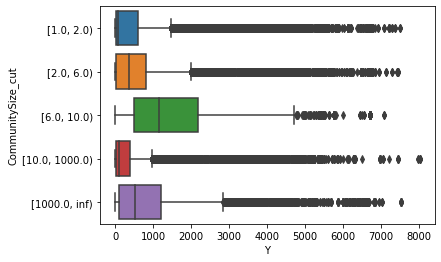

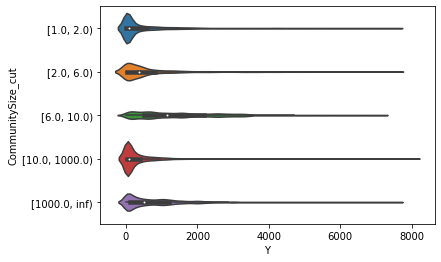

In [135]:
sns.boxplot(data=df, x="Y", y=column_cut)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

{0: Interval(1.0, 2.0, closed='left'), 1: Interval(2.0, 6.0, closed='left'), 2: Interval(6.0, 10.0, closed='left'), 3: Interval(10.0, 1000.0, closed='left'), 4: Interval(1000.0, inf, closed='left')}
dict_keys([0, 1, 2, 3, 4])
values_list = dict_keys([0, 1, 2, 3, 4])


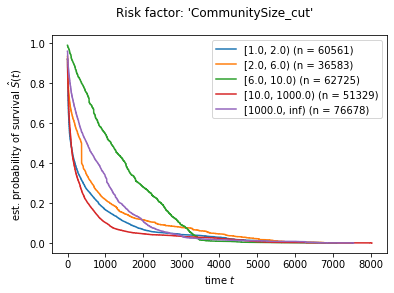

<Figure size 432x288 with 0 Axes>

In [136]:
print(values_names)
print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

<AxesSubplot: xlabel='CommunitySize', ylabel='Y'>

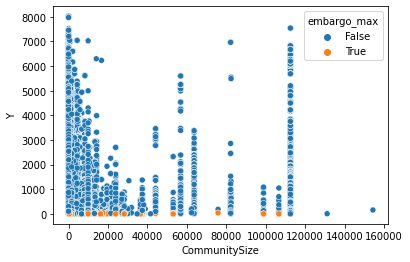

In [137]:
sns.scatterplot(data=df, x='CommunitySize', y='Y', hue='embargo_max')

### NumFiles and NumBlobs

In [138]:
column_name='NumFiles'

In [139]:
df['NumFiles'].describe()

count    2.878840e+05
mean     5.705731e+05
std      1.714456e+06
min      1.000000e+00
25%      2.896700e+04
50%      1.055120e+05
75%      3.155660e+05
max      4.307279e+07
Name: NumFiles, dtype: float64

<AxesSubplot: xlabel='Y'>

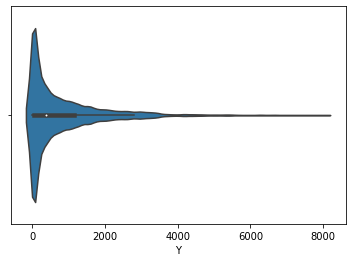

In [140]:
sns.violinplot(data=df[['Y','NumFiles']], x="Y")

<AxesSubplot: ylabel='Count'>

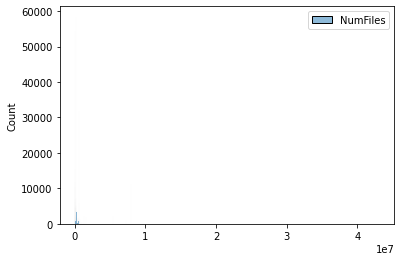

<AxesSubplot: ylabel='Count'>

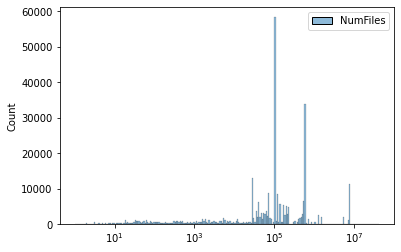

In [141]:
sns.histplot(data=df[[column_name]].dropna())
plt.show()
sns.histplot(data=df[[column_name]].dropna(), log_scale=True)
plt.show()

NumFiles_cut
[1.0, 50.0)              12781
[50.0, 1000.0)           21239
[1000.0, 100000.0)       85700
[100000.0, 500000.0)    104537
[500000.0, inf)          63627
dtype: int64

CategoricalDtype(categories=[[1.0, 50.0), [50.0, 1000.0), [1000.0, 100000.0), [100000.0, 500000.0), [500000.0, inf)], ordered=True)

<AxesSubplot: xlabel='NumFiles_cut', ylabel='CVE+project'>

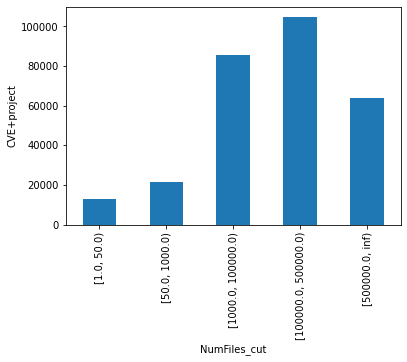

In [142]:
column_cut = column_name + '_cut'

cut_s = pd.cut(df[column_name].dropna(),
                  bins=[1,50,1e3,1e5,5e5,np.inf],right=False,include_lowest=True)
df[column_cut] = cut_s
display(df.value_counts(column_cut).sort_index())
display(cut_s.dtype)

df.value_counts(column_cut).sort_index().plot.bar(ylabel='CVE+project')

In [143]:
ranking_list = create_values_ranking_list(df[column_cut], df[column_cut].dtype)
(values_hash, values_names) = values_ranking_hashes(ranking_list)

#display(ranking_list)
#display(values_hash)
display(values_names)

{0: Interval(1.0, 50.0, closed='left'),
 1: Interval(50.0, 1000.0, closed='left'),
 2: Interval(1000.0, 100000.0, closed='left'),
 3: Interval(100000.0, 500000.0, closed='left'),
 4: Interval(500000.0, inf, closed='left')}

In [144]:
df_mask=None
f_map = lambda row: f_map_generic(row, column_cut, values_hash)
params = {
    'bootstrap_samples': 50,
    'confidence': 0.95,
    'risk_column_name': column_cut,
}
(ret, groups, ddf) = apply_stats_for_each_value(params, df, f_map, condition_names=values_names, df_mask=df_mask)

print(json.dumps(ret, indent=4))
display(groups)

all = 287884, selected = 287884, uncensored = 287884
Computing 50 × bootstrap Dxy for 287884 elements...
Computing confidence interval from 50 samples...


{
    "Cohort": 287884,
    "Number of patients": 287884.0,
    "% of cohort": 100.0,
    "Survival days, median": 368.0,
    "Survival years, median": 1.0082191780821919,
    "Dxy (full)": 0.1622145546229783,
    "bootstrap": {
        "Dxy": 0.16209762273840664,
        "Confidence interval low": 0.16179808986158012,
        "Confidence interval high": 0.16239715561523316,
        "confidence threshold %": 95.0,
        "bootstrap samples": 50
    }
}


Computing descriptive statistics like mean, median, etc....


,count,median,min,25%,75%,max,mean,std,skew
NumFiles_cut,,,,,,,,,
"[1.0, 50.0)",12781,83.0,0,9.0,561.0,6384,439.406306,732.983816,2.725725
"[50.0, 1000.0)",21239,89.0,0,8.0,370.0,6592,385.478883,689.300688,3.337644
"[1000.0, 100000.0)",85700,170.0,0,21.0,691.0,8019,683.354259,1239.970189,2.675431
"[100000.0, 500000.0)",104537,599.0,0,100.0,1574.0,6967,976.920717,1033.997007,1.108726
"[500000.0, inf)",63627,610.0,0,142.0,1289.0,7538,899.829632,1008.682508,2.272802


In [145]:
results_summary[column_cut] = {
    '% of cohort': ret['% of cohort'],
    'Dxy': ret['bootstrap']['Dxy'],
    'Dxy_low': ret['bootstrap']['Confidence interval low'],
    'Dxy_high': ret['bootstrap']['Confidence interval low'],
}

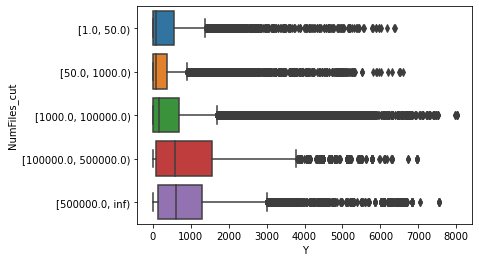

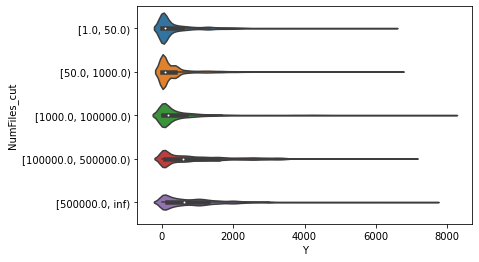

In [146]:
sns.boxplot(data=df, x="Y", y=column_cut)
plt.show();
sns.violinplot(data=df, x="Y", y=column_cut)
plt.show();

values_list = dict_keys([0, 1, 2, 3, 4])


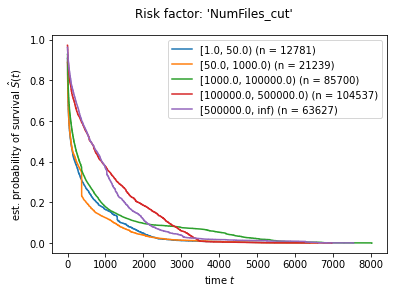

<Figure size 432x288 with 0 Axes>

In [147]:
#print(values_names)
#print(values_names.keys())
plot_survival_function(params, ddf, condition_names=values_names)

<AxesSubplot: xlabel='NumFiles', ylabel='Y'>

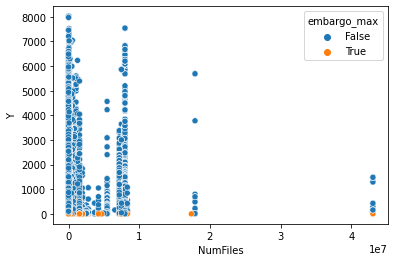

In [148]:
sns.scatterplot(data=df, x=column_name, y='Y', hue='embargo_max')

<AxesSubplot: xlabel='NumFiles', ylabel='Y'>

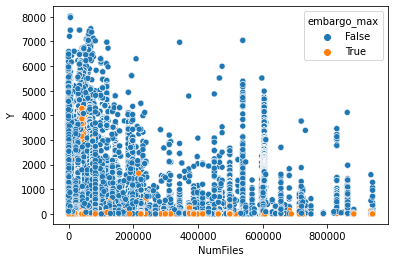

In [149]:
sns.scatterplot(data=df[df['NumFiles']<1e6], x=column_name, y='Y', hue='embargo_max')

----
**NumBlobs**

<AxesSubplot: xlabel='NumFiles', ylabel='NumBlobs'>

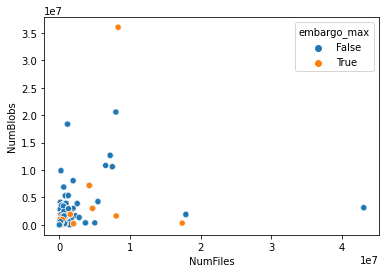

<AxesSubplot: xlabel='NumFiles', ylabel='NumBlobs'>

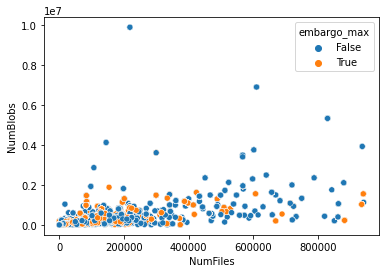

In [150]:
sns.scatterplot(data=df, x='NumFiles', y='NumBlobs', hue='embargo_max')
plt.show()
sns.scatterplot(data=df[df['NumFiles']<1e6], x='NumFiles', y='NumBlobs', hue='embargo_max')
plt.show()

## Summary

In [151]:
summary_df=pd.DataFrame.from_dict(results_summary, orient='index')
summary_df

,% of cohort,Dxy,Dxy_low,Dxy_high
NumCore_cut,99.706826,-0.028314,-0.028634,-0.028634
NumAuthors_cut,99.706826,-0.044276,-0.044664,-0.044664
NumCore/NumAuthors cut,99.706826,0.154053,0.153814,0.153814
NumCommits_cut,99.899612,-0.124792,-0.125110,-0.125110
NumCommits_cut2,99.899612,-0.107373,-0.107709,-0.107709
NumActiveMon [%] cut,99.999305,-0.132195,-0.132584,-0.132584
NumActiveMon_cut,100.000000,-0.098587,-0.098924,-0.098924
CommitDateRange [days] cut,100.000000,-0.041689,-0.041949,-0.041949
NumStars_cut,79.257270,-0.074789,-0.075122,-0.075122
NumStars_cut+NumStars<10000,59.342305,-0.286811,-0.287202,-0.287202


In [152]:
ver='1'
summary_df.to_csv(f"survey_analysis_project_metadata-{ver}.csv")